# Project 2
## Shangzhe Wu, Xinnan Du, Gengmo Qi, Boyu Liu
This is a experimental project intending to reimplement similar phenomenons in papers:

(1) Understanding deep learning requires rethinking generalization

(2) Theory of Deep Learning III: the non-overitting puzzle.

### Work distribution:
Shangzhe Wu: Section 1

Xinnan Du: Section 2

Gengmo Qi: Section 4

Boyu Liu: Section 3

## Section 1: Experiments on random/true lable and random/shuffle/true lable

• True labels: the original dataset without modification.

• Random labels: all the labels are replaced with random ones.

• Shuffled pixels: a random permutation of the pixels is chosen and then the same permutation
is applied to all the images in both training and test set.

• Random pixels: a different random permutation is applied to each image independently.

• Gaussian: A Gaussian distribution (with matching mean and variance to the original image
dataset) is used to generate random pixels for each image.

### random_test_gaussian_pixels

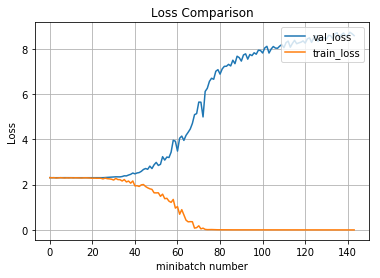

In [13]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss[::300])
plt.plot(losses[::300])

plt.legend(['val_loss', 'train_loss'], loc='upper right')

plt.show()

### random_test_random_label

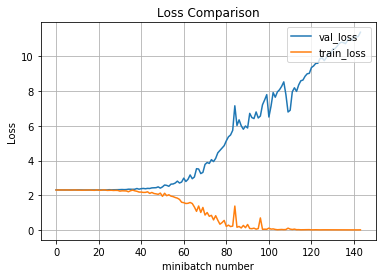

In [16]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss[::300])
plt.plot(losses[::300])

plt.legend(['val_loss', 'train_loss'], loc='upper right')

plt.show()

### random_test_random_pixels

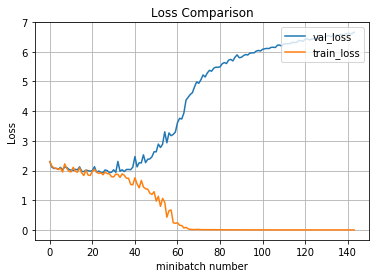

In [30]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss[::300])
plt.plot(losses[::300])

plt.legend(['val_loss', 'train_loss'], loc='upper right')

plt.show()

### random_test_shuffled_pixels

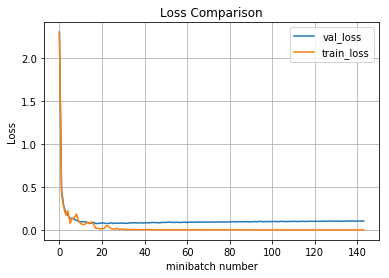

In [8]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss[::300])
plt.plot(losses[::300])

plt.legend(['val_loss', 'train_loss'], loc='upper right')

plt.show()

### random_test_true_label

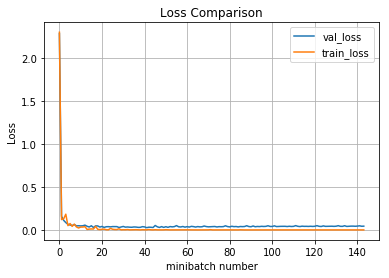

In [8]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss[::300])
plt.plot(losses[::300])

plt.legend(['val_loss', 'train_loss'], loc='upper right')

plt.show()

### Discussion
These results have reproduced the results in paper "Understanding deep learning requires rethinking generalization". However random and unordered the training data is, the model can always overfit the training set and loss become zero. For the validation set, only if the validation data has a underlying distribution same as training data, the loss could be reduced to a low value. If not, the validation loss will be very high.

## Section2: Implicit Regularization
In this section, we discuss implicit regularization effect of early stopping and batch normalization. As our computation resource is limited, we will use a simple CNN model and MNIST data set.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)

### Model without Batch Normalization
The below cell defines the architecture of a simple CNN without batch normalization, it consists of two convolution layer and two fully connected layer. 
The architecture is illustrated in the figure below
<img src="https://www.tensorflow.org/images/cifar_graph.png" width="100">

In [29]:
def cnn_model(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    # dropout = tf.layers.dropout(
    #  inputs=dense, rate=0.4, training=is_training)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

Below cell specifies the training procedure

In [30]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, xVal=None, yVal=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), tf.cast(y, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    val_idxs = random.sample(range(10000), 1000)
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    varLoss = []
    losses = []
    varAcc = []
    acc = []
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss)
            correct += np.sum(corr)
            train_acc = np.sum(corr)/actual_batch_size
            acc.append(train_acc)
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,train_acc))
            iter_cnt += 1
            if xVal is not None:
                val_idx = idx % xVal.shape[1]
                val_loss, val_acc = session.run([mean_loss, accuracy], feed_dict={
                    X: xVal[val_idxs],
                    y: yVal[val_idxs],
                    is_training: False
                })
                varLoss.append(val_loss)
                varAcc.append(val_acc)
            
        if xVal is not None:
            val_idx = idx % xVal.shape[1]
            val_loss, val_acc = session.run([mean_loss, accuracy], feed_dict={
                X: xVal[:200],
                y: yVal[:200],
                is_training: False
            })
            print(val_loss, val_acc)
                
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
    if plot_losses and xVal is not None:
        # training loss
        plt.plot(losses)
        plt.grid(True)
        plt.title('Train Loss')
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
        # validation loss
        plt.plot(varLoss)
        plt.grid(True)
        plt.title('Val Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('loss')
        plt.show()
        # training acc
        plt.plot(acc)
        plt.grid(True)
        plt.title('acc'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('acc')
        plt.show()
        # validation acc
        plt.plot(varAcc)
        plt.grid(True)
        plt.title('Val Acc'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('acc')
        plt.show()
    return total_loss,total_correct, varLoss, losses, varAcc, acc

For loss function, we will use cross-entropy loss with no explicit regularization

In [31]:
def loss(logits, labels):
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    labels = tf.argmax(labels, axis=1)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
    regularizor = 0
    #for weight in weights:
    #    regularizor += tf.nn.l2_loss(weight)
    cross_entropy_mean = tf.reduce_mean(cross_entropy + 0.01 * regularizor)

    return tf.add_n(tf.get_collection('losses'))

In [32]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

load mnist data

In [33]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [34]:
eval_labels.shape

(10000,)

Train the model without batch normalization on mnist dataset, as the dataset is simple, one epoch is enough to overfit the data

In [35]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
_, _, varLoss, losses, varAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.29 and accuracy of 0.2
Iteration 100: with minibatch training loss = 0.368 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.175 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.104 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.165 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.204 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.167 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.127 and accuracy of 0.94
Iteration 800: with minibatch training loss = 0.183 and accuracy of 0.95
0.025682338 0.995
Epoch 1, Overall loss = 0.00408 and accuracy of 0.922


### Model with Batch Normalization
The architecture is the same as the one defined above except we insert batch normalization layer after each conv layer

In [36]:
def cnn_model_bn(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    # bn1
    bn1 = tf.layers.batch_normalization(conv1, axis=3, training=is_training)
    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=bn1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    #bn2
    bn2 = tf.layers.batch_normalization(conv2, axis=3, training=is_training)
    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    # dropout = tf.layers.dropout(
    #  inputs=dense, rate=0.4, training=is_training)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [37]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_bn(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [38]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
_, _, varLoss_bn, losses_bn, varAcc_bn, acc_bn = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 3.72 and accuracy of 0.11
Iteration 100: with minibatch training loss = 0.132 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.322 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.0419 and accuracy of 1
Iteration 400: with minibatch training loss = 0.185 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.009 and accuracy of 1
Iteration 600: with minibatch training loss = 0.0378 and accuracy of 1
Iteration 700: with minibatch training loss = 0.0333 and accuracy of 1
Iteration 800: with minibatch training loss = 0.102 and accuracy of 0.97
0.039626498 0.98
Epoch 1, Overall loss = 0.00424 and accuracy of 0.942


## Compare the results

Visualize losses

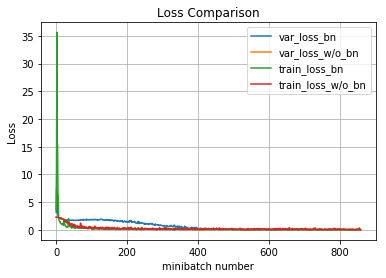

In [39]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss_bn)
plt.plot(varLoss)
plt.plot(losses_bn)
plt.plot(losses)

plt.legend(['var_loss_bn', 'var_loss_w/o_bn', 'train_loss_bn', 'train_loss_w/o_bn'], loc='upper right')

plt.show()

Visualize accuracy

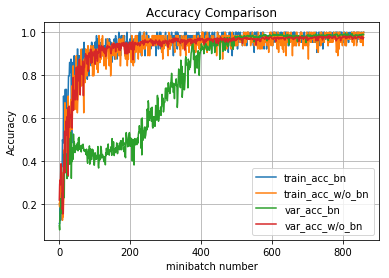

In [40]:
plt.grid(True)
plt.title('Accuracy Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Accuracy')
plt.plot(acc_bn)
plt.plot(acc)
plt.plot(varAcc_bn)
plt.plot(varAcc)

plt.legend(['train_acc_bn', 'train_acc_w/o_bn', 'var_acc_bn', 'var_acc_w/o_bn'], loc='lower right')

plt.show()

## Discussion
### 1. Early Stopping
As the data is simple, both models' validation accuracy remain close to 1 when the nimibatch number reach certain threshold. Thus, the implicit regularization effect could not be clearly observed. The paper also points out that the implicit regularization is more obvious on large dataset such as imagenet, but on small dataset like cifar10, early stopping couldn't bring any benefit.
### 2. Batch Normalization
Batch normalization indeed improves the generalization performance as shown in Accuracy Comparison.  After 600 minibatch, although validation accuracies for both models are close to 1, the validation accuracy of the model with batch norm is slightly higher than the one without batch norm, as the dataset is simple, a small difference in validation accuracy means a lot.
You might have observed that the validation accuracy of the model with batch norm is relatively low before 400 minibatch. This due to the nature of batch normalization, when performing inference, batch norm use the statistics of the observed data in training rature than the current batch. In the first few minibatchs, the observed data is limited, thus the test performance is poor, but after the model observed enough samples, the validation accuracy increases rapidly as shown in the graph. 

## Section 3: Explitcit Regularization
Here we conduct experiment on a normally used way of regularization: L2 Loss on parameters. This is also known as weight decay.

In [19]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model(X,y,is_training)


In [20]:
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [23]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())
_, _, varLoss, losses, varAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,5,64,400,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.094
Iteration 400: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 800: with minibatch training loss = 0.0518 and accuracy of 0.98
0.04942652 0.995
Epoch 1, Overall loss = 0.00437 and accuracy of 0.914
Iteration 1200: with minibatch training loss = 0.112 and accuracy of 0.94
Iteration 1600: with minibatch training loss = 0.0314 and accuracy of 1
0.017824816 1.0
Epoch 2, Overall loss = 0.00549 and accuracy of 0.978
Iteration 2000: with minibatch training loss = 0.0323 and accuracy of 1
Iteration 2400: with minibatch training loss = 0.00529 and accuracy of 1
0.010724336 1.0
Epoch 3, Overall loss = 0.00625 and accuracy of 0.985
Iteration 2800: with minibatch training loss = 0.00415 and accuracy of 1
Iteration 3200: with minibatch training loss = 0.0071 and accuracy of 1
0.009313009 1.0
Epoch 4, Overall loss = 0.00684 and accuracy of 0.989
Iteration 3600: with minibatch training loss = 0.00736 and accurac

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model(X,y,is_training)


In [25]:
WEIGHT_DECAY_FACTOR = 0.0005
tvars = tf.trainable_variables()
print(tvars)
with tf.variable_scope('weights_norm') as scope:
    weights_norm = tf.reduce_mean(
      input_tensor = WEIGHT_DECAY_FACTOR*tf.stack(
          [tf.nn.l2_loss(i) for i in tvars]
      ),
    name='weights_norm'
    )

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'conv2d/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2d_1/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2d_1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'dense_1/kernel:0' shape=(1024, 10) dtype=float32_ref>, <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>]


In [26]:
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10)) + weights_norm

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [27]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, varLoss_decay, losses_decay, varAcc_decay, acc_decay = run_model(sess,y_out,mean_loss,train_data,train_labels,5,64,400,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.35 and accuracy of 0.16
Iteration 400: with minibatch training loss = 0.134 and accuracy of 0.98
Iteration 800: with minibatch training loss = 0.0788 and accuracy of 1
0.11381226 0.975
Epoch 1, Overall loss = 0.00519 and accuracy of 0.915
Iteration 1200: with minibatch training loss = 0.131 and accuracy of 0.98
Iteration 1600: with minibatch training loss = 0.107 and accuracy of 0.97
0.07164418 1.0
Epoch 2, Overall loss = 0.00708 and accuracy of 0.978
Iteration 2000: with minibatch training loss = 0.154 and accuracy of 0.97
Iteration 2400: with minibatch training loss = 0.0639 and accuracy of 1
0.061764598 1.0
Epoch 3, Overall loss = 0.00862 and accuracy of 0.985
Iteration 2800: with minibatch training loss = 0.0656 and accuracy of 1
Iteration 3200: with minibatch training loss = 0.0558 and accuracy of 1
0.062620565 0.995
Epoch 4, Overall loss = 0.00999 and accuracy of 0.989
Iteration 3600: with minibatch training loss = 0.0907 and accuracy

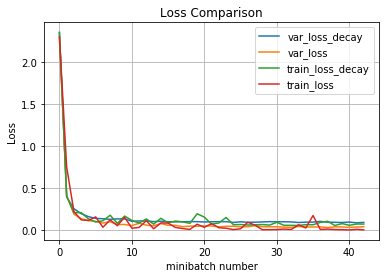

In [30]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(varLoss_decay[::100])
plt.plot(varLoss[::100])
plt.plot(losses_decay[::100])
plt.plot(losses[::100])

plt.legend(['var_loss_decay', 'var_loss', 'train_loss_decay', 'train_loss'], loc='upper right')

plt.show()

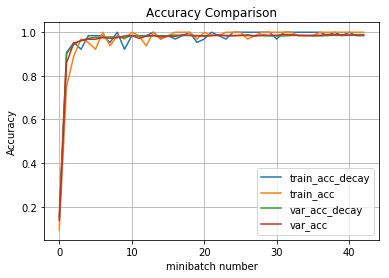

In [31]:
plt.grid(True)
plt.title('Accuracy Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Accuracy')
plt.plot(acc_decay[::100])
plt.plot(acc[::100])
plt.plot(varAcc_decay[::100])
plt.plot(varAcc[::100])

plt.legend(['train_acc_decay', 'train_acc', 'var_acc_decay', 'var_acc'], loc='lower right')

plt.show()

## Discussion
Normally, 
As shown in the above graphs. Weight decay does not convincingly improve generalization. This might indicate that this commonly used external regularization does not have its power in neural networks.

## Section 4: On test error and loss

2.Non-overfitting of test error and overfitting of test loss when model complexity grows. Train
several CNNs (ResNet) of different number of parameters, stop your SGD at certain large enough
epochs (e.g. 1000) or zero training error (misclassification) is reached. Then compare the test
(validation) error or test loss as model complexity grows to see if you observe similar phenomenon
in Figure 2: when training error becomes zero, test error (misclassification) does not overfit but
test loss (e.g. cross-entropy, exponential) shows overfitting as model complexity grows. This is for
reproducing experiments in the following paper:

**Tomaso Poggio, K. Kawaguchi, Q. Liao, B. Miranda, L. Rosasco, X. Biox, J. Hidary, and H.
Mhaskar. Theory of Deep Learning III: the non-overfiing puzzle. Jan 30, 2018.** [http://cbmm.mit.edu/publications/theory-deep-learning-iii-explaining-non-overfitting-puzzle]

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.INFO)
all_training_error = []
all_training_loss = []
all_test_error = []
all_test_loss = []

### 1. 3*10^6 Model Parameters:
```7 * 7 * 64 * 1024 ≈ 3 * 10^6 ```

In [2]:
def cnn_model_1(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    # dropout = tf.layers.dropout(
    #  inputs=dense, rate=0.4, training=is_training)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, xVal=None, yVal=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), tf.cast(y, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    val_idxs = random.sample(range(10000), 1000)
    train_idxs = random.sample(range(50000), 1000)
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    valLoss = []
    losses = []
    valAcc = []
    acc = []
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss)
            correct += np.sum(corr)
            train_acc = np.sum(corr)/actual_batch_size
            acc.append(train_acc)
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,train_acc))
            iter_cnt += 1
            if xVal is not None:
                val_idx = idx % xVal.shape[1]
                val_loss, val_acc = session.run([mean_loss, accuracy], feed_dict={
                    X: xVal[val_idxs],
                    y: yVal[val_idxs],
                    is_training: False
                })
                valLoss.append(val_loss)
                valAcc.append(val_acc)
            
        if xVal is not None:
            val_idx = idx % xVal.shape[1]
            val_loss, val_acc = session.run([mean_loss, accuracy], feed_dict={
                X: xVal[val_idxs],
                y: yVal[val_idxs],
                is_training: False
            })
    
    feed_dict = {X: Xd[train_idxs,:],y: yd[train_idxs],is_training: training_now }
    # have tensorflow compute loss and correct predictions
    # and (if given) perform a training step
    loss, corr, _ = session.run(variables,feed_dict=feed_dict)
    actual_batch_size = yd[train_idxs].shape[0]
    train_acc = np.sum(corr)/actual_batch_size
    print('----------------------------------------------------------------------')
    print('test loss', valLoss[-1])
    all_test_loss.append(valLoss[-1])
    print('test error', 1 - valAcc[-1])
    all_test_error.append(1 - valAcc[-1])
            
    total_correct = correct/Xd.shape[0]
    total_loss = np.sum(losses)/Xd.shape[0]
    print('training loss',loss)
    all_training_loss.append(loss)
    print('training error', 1 - train_acc)
    all_training_error.append(1 - train_acc)

        
        # print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\.format(total_loss,total_correct,e+1))
    if plot_losses and xVal is not None:
        # training loss
        plt.plot(losses)
        plt.grid(True)
        plt.title('Train Loss')
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()
        # validation loss
        plt.plot(valLoss)
        plt.grid(True)
        plt.title('Val Loss'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('loss')
        plt.show()
        # training acc
        plt.plot(acc)
        plt.grid(True)
        plt.title('acc'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('acc')
        plt.show()
        # validation acc
        plt.plot(valAcc)
        plt.grid(True)
        plt.title('Val Acc'.format(e+1))
        plt.xlabel('minibatch number')
        plt.ylabel('acc')
        plt.show()
    return total_loss,total_correct, valLoss, losses, valAcc, acc

In [4]:
def loss(logits, labels):
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64)
    labels = tf.argmax(labels, axis=1)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
    regularizor = 0
    #for weight in weights:
    #    regularizor += tf.nn.l2_loss(weight)
    cross_entropy_mean = tf.reduce_mean(cross_entropy + 0.01 * regularizor)

    return tf.add_n(tf.get_collection('losses'))

In [5]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_1(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [6]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


In [7]:
train_labels.shape

(55000,)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.11
Iteration 100: with minibatch training loss = 0.301 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.127 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.363 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.167 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.195 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.134 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 800: with minibatch training loss = 0.128 and accuracy of 0.97
----------------------------------------------------------------------
test loss 0.116666
test error 0.0339999198914
training loss 0.148562
training error 0.049


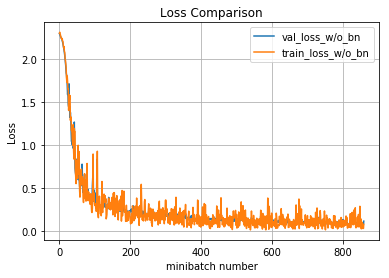

In [9]:
plt.grid(True)
plt.title('Loss Comparison')
plt.xlabel('minibatch number')
plt.ylabel('Loss')
plt.plot(valLoss)
plt.plot(losses)

plt.legend(['val_loss_w/o_bn', 'train_loss_w/o_bn'], loc='upper right')

plt.show()

In [10]:
import pickle
with open('objs.pkl', 'wb') as f:
    pickle.dump([valLoss, losses, acc, valAcc], f)

### 2. 1.6 * 10^6 Model Parameters:
```7 * 7 * 64 * 512 ≈ 1.6 * 10^6 ```

In [11]:
def cnn_model_2(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 512]
    dense = tf.layers.dense(inputs=pool2_flat, units=512, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [12]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_2(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.28 and accuracy of 0.19
Iteration 100: with minibatch training loss = 0.549 and accuracy of 0.78
Iteration 200: with minibatch training loss = 0.0662 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.137 and accuracy of 0.97
Iteration 400: with minibatch training loss = 0.0834 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.137 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.0166 and accuracy of 1
Iteration 800: with minibatch training loss = 0.0735 and accuracy of 0.98
----------------------------------------------------------------------
test loss 0.0557393
test error 0.0210000276566
training loss 0.0621408
training error 0.023


### 3. 8* 10^5 Model Parameters:
```7 * 7 * 64 * 256 ≈ 8 * 10^5 ```

In [14]:
def cnn_model_3(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 256]
    dense = tf.layers.dense(inputs=pool2_flat, units=256, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [15]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_3(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.078
Iteration 100: with minibatch training loss = 0.457 and accuracy of 0.91
Iteration 200: with minibatch training loss = 0.286 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.156 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.179 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.296 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.283 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.0607 and accuracy of 0.97
Iteration 800: with minibatch training loss = 0.0511 and accuracy of 0.97
----------------------------------------------------------------------
test loss 0.097099
test error 0.0319999456406
training loss 0.122339
training error 0.039


### 4. 4* 10^5 Model Parameters:
```7 * 7 * 64 * 128 ≈ 4 * 10^5 ```

In [17]:
def cnn_model_4(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 128]
    dense = tf.layers.dense(inputs=pool2_flat, units=128, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [18]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_4(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.31 and accuracy of 0.12
Iteration 100: with minibatch training loss = 0.524 and accuracy of 0.89
Iteration 200: with minibatch training loss = 0.335 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.172 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.225 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.226 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.0235 and accuracy of 1
Iteration 800: with minibatch training loss = 0.0212 and accuracy of 1
----------------------------------------------------------------------
test loss 0.0830984
test error 0.0259999632835
training loss 0.0861081
training error 0.029


### 5. 10^5 Model Parameters:
```7 * 7 * 64 * 64 ≈ 2 * 10^5 ```

In [20]:
def cnn_model_5(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 64]
    dense = tf.layers.dense(inputs=pool2_flat, units=64, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [21]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_5(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.33 and accuracy of 0.062
Iteration 100: with minibatch training loss = 0.444 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.222 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.145 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.17 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.123 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.0392 and accuracy of 1
Iteration 700: with minibatch training loss = 0.16 and accuracy of 0.94
Iteration 800: with minibatch training loss = 0.132 and accuracy of 0.94
----------------------------------------------------------------------
test loss 0.120594
test error 0.027999997139
training loss 0.116395
training error 0.028


### 6. 1 * 10^5 Model Parameters:
```7 * 7 * 64 * 32 ≈ 1 * 10^5 ```

In [23]:
def cnn_model_6(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 32]
    dense = tf.layers.dense(inputs=pool2_flat, units=32, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [24]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_6(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.3 and accuracy of 0.16
Iteration 100: with minibatch training loss = 0.645 and accuracy of 0.83
Iteration 200: with minibatch training loss = 0.264 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.144 and accuracy of 0.97
Iteration 400: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.374 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.111 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.0876 and accuracy of 0.98
Iteration 800: with minibatch training loss = 0.0332 and accuracy of 1
----------------------------------------------------------------------
test loss 0.0961001
test error 0.0349999070168
training loss 0.105667
training error 0.035


### 7.  5 * 10^4 Model Parameters:
```7 * 7 * 64 * 16 ≈ 5 * 10^4 ```

In [26]:
def cnn_model_7(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 16]
    dense = tf.layers.dense(inputs=pool2_flat, units=16, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [27]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_7(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.29 and accuracy of 0.094
Iteration 100: with minibatch training loss = 0.738 and accuracy of 0.72
Iteration 200: with minibatch training loss = 0.283 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.0905 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.412 and accuracy of 0.86
Iteration 500: with minibatch training loss = 0.181 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.0368 and accuracy of 1
Iteration 700: with minibatch training loss = 0.0967 and accuracy of 0.97
Iteration 800: with minibatch training loss = 0.115 and accuracy of 0.97
----------------------------------------------------------------------
test loss 0.0856809
test error 0.027999997139
training loss 0.0770738
training error 0.019


### 8.  2.5 * 10^4 Model Parameters:
```7 * 7 * 32 * 16 ≈ 2.5 * 10^4 ```

In [29]:
def cnn_model_8(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 32])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 32]
    # Output Tensor Shape: [batch_size, 16]
    dense = tf.layers.dense(inputs=pool2_flat, units=16, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [30]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_8(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [31]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.33 and accuracy of 0.094
Iteration 100: with minibatch training loss = 0.86 and accuracy of 0.78
Iteration 200: with minibatch training loss = 0.302 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.163 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.209 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.184 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.383 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.0884 and accuracy of 0.97
Iteration 800: with minibatch training loss = 0.106 and accuracy of 0.95
----------------------------------------------------------------------
test loss 0.0911833
test error 0.0269999504089
training loss 0.100819
training error 0.022


### 9.  1.2 * 10^4 Model Parameters:
```7 * 7 * 16 * 16 ≈ 1.2 * 10^4 ```

In [32]:
def cnn_model_9(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,filters=16,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 16])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 16]
    # Output Tensor Shape: [batch_size, 16]
    dense = tf.layers.dense(inputs=pool2_flat, units=16, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [33]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_9(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [34]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.33 and accuracy of 0.078
Iteration 100: with minibatch training loss = 0.693 and accuracy of 0.8
Iteration 200: with minibatch training loss = 0.182 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.214 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.216 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.127 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.18 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.0963 and accuracy of 0.97
Iteration 800: with minibatch training loss = 0.0986 and accuracy of 0.97
----------------------------------------------------------------------
test loss 0.0996784
test error 0.0299999713898
training loss 0.110584
training error 0.03


### 10. 6* 10 ^3 Model Parameters:
```7 * 7 * 8 * 16 ≈ 6 * 10^3 ```

In [35]:
def cnn_model_10(features, labels, is_training):
    """Model function for CNN."""
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    conv1 = tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    conv2 = tf.layers.conv2d(inputs=pool1,filters=8,kernel_size=[5, 5],
      padding="same",activation=tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 8])

    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 7 * 7 * 8]
    # Output Tensor Shape: [batch_size, 16]
    dense = tf.layers.dense(inputs=pool2_flat, units=16, activation=tf.nn.relu)

    logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [36]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out= cnn_model_10(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
mean_loss = loss(y_out, tf.one_hot(y,10))

# define our optimizer
global_step = tf.contrib.framework.get_or_create_global_step()
optimizer = tf.train.GradientDescentOptimizer(tf.train.exponential_decay(0.05, global_step, 500, 0.1, staircase=True))
# optimizer = tf.train.AdamOptimizer(learning_rate=0.0008,beta1=0.9,beta2=0.999,epsilon=1e-08)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [37]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
_, _, valLoss, losses, valAcc, acc = run_model(sess,y_out,mean_loss,train_data,train_labels,1,64,100,train_step,False, xVal=eval_data, yVal=eval_labels)

Iteration 0: with minibatch training loss = 2.31 and accuracy of 0.094
Iteration 100: with minibatch training loss = 0.62 and accuracy of 0.89
Iteration 200: with minibatch training loss = 0.204 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.334 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.171 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.142 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.0752 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.204 and accuracy of 0.94
Iteration 800: with minibatch training loss = 0.106 and accuracy of 0.97
----------------------------------------------------------------------
test loss 0.168304
test error 0.0469999313354
training loss 0.125033
training error 0.044


In [38]:
print('all_training_error',all_training_error)
print('all_training_loss',all_training_loss)
print('all_test_error',all_test_error)
print('all_test_loss',all_test_loss)

all_training_error [0.049000000000000044, 0.02300000000000002, 0.039000000000000035, 0.029000000000000026, 0.028000000000000025, 0.035000000000000031, 0.019000000000000017, 0.02200000000000002, 0.030000000000000027, 0.044000000000000039]
all_training_loss [0.14856194, 0.062140841, 0.12233914, 0.086108103, 0.11639526, 0.10566651, 0.077073783, 0.10081871, 0.11058394, 0.12503318]
all_test_error [0.033999919891357422, 0.021000027656555176, 0.031999945640563965, 0.025999963283538818, 0.027999997138977051, 0.03499990701675415, 0.027999997138977051, 0.026999950408935547, 0.029999971389770508, 0.046999931335449219]
all_test_loss [0.11666585, 0.055739317, 0.097098961, 0.083098419, 0.12059435, 0.096100129, 0.085680895, 0.091183349, 0.09967839, 0.16830353]


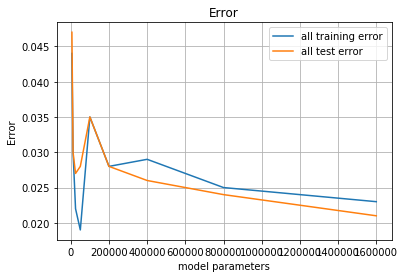

In [45]:
x_axis = ['1600000', '800000', '400000', '200000', '100000','50000', '25000', '12000', '6000']
plt.grid(True)

# fig, ax = plt.subplots()
# ax.plot(x_axis, all_training_error, label="all_training_error")
# ax.plot(x_axis, all_test_error, label="all_test_error")
# ax.legend(loc='upper right')

# plt.show()
plt.title('Error')
plt.xlabel('model parameters')
plt.ylabel('Error')
plt.plot(x_axis, all_training_error)
plt.plot(x_axis, all_test_error)

plt.legend(['all training error', 'all test error'], loc='upper right')

plt.show()

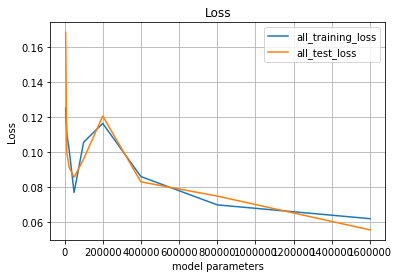

In [46]:
x_axis = ['1600000', '800000', '400000', '200000', '100000','50000', '25000', '12000', '6000']
plt.grid(True)
# fig, ax = plt.subplots()
# ax.plot(x_axis, all_training_error, label="all_training_error")
# ax.plot(x_axis, all_test_error, label="all_test_error")
# ax.legend(loc='upper right')

# plt.show()
plt.title('Loss')
plt.xlabel('model parameters')
plt.ylabel('Loss')
plt.plot(x_axis, all_training_loss)
plt.plot(x_axis, all_test_loss)

plt.legend(['all_training_loss', 'all_test_loss'], loc='upper right')

plt.show()

### Discussion
We did NOT observe a similar phenomenon with the one presented in the paper by Poggio et al. We believe the reasons could be the following:
Poggio et al. had more observations up to 10^7, and the phenomenon they observed appeared around the range of 10^5, whereas we have plotted much less data points(we collected the result for 10 different model parameters only)
